In [7]:
#importing required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import joblib
from sqlalchemy import create_engine

#Analalytical Question</br>
Can we predict hourly  bike rental demand and what are the factors that influence the demand?

In [ ]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'racharya001' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [9]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [10]:
table_name = r'bike_features'
schema = r'cleaned' # schema were the data was loaded last week.

df = pd.read_sql_table(table_name, db_conn, schema)

In [11]:
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered,cnt,hr_category,day_type,temp_diff,is_daytime,day_type_ind,cnt_lag1,cnt_rolling_3,cnt_rolling_6
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,13,16,3,weekend,0.047900,0,1,189.463088,189.463088,189.463088
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,32,40,3,weekend,0.052700,0,1,16.000000,189.463088,189.463088
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,27,32,3,weekend,0.224479,0,1,40.000000,29.333333,189.463088
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,10,13,3,weekend,0.047900,0,1,32.000000,28.333333,189.463088
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,1,1,3,weekend,0.047900,0,1,13.000000,15.333333,189.463088
5,6,2011-01-01,1,0,1,5,0,6,0,2,...,1,1,2,weekend,0.017600,0,1,1.000000,5.000000,17.166667
6,7,2011-01-01,1,0,1,6,0,6,0,1,...,0,2,2,weekend,0.224479,1,1,1.000000,1.333333,14.833333
7,8,2011-01-01,1,0,1,7,0,6,0,1,...,2,3,2,weekend,0.057600,1,1,2.000000,2.000000,8.666667
8,9,2011-01-01,1,0,1,8,0,6,0,1,...,7,8,2,weekend,0.047900,1,1,3.000000,4.333333,4.666667
9,10,2011-01-01,1,0,1,9,0,6,0,1,...,6,14,2,weekend,0.028500,1,1,8.000000,8.333333,4.833333


First, of all we will take all the features column for machine laerning except some which we will be droppig below which wont come handy for the algorithm.

In [13]:
# Drop unnecessary columns which will not be used in machine learnin
df = df.drop(columns=["instant", "dteday", "casual", "registered","day_type"])

In [14]:
# Defining features and target variable
target = "cnt"
features = [col for col in df.columns if col != target]

In [15]:
#Spliting data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(df[features], df[target], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# Standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Converting back to DataFrame for easier interpretation
X_train = pd.DataFrame(X_train_scaled, columns=features)
X_val = pd.DataFrame(X_val_scaled, columns=features)
X_test = pd.DataFrame(X_test_scaled, columns=features)

In [18]:
# Training a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
# Making predictions on validation set
y_val_pred = model.predict(X_val)

In [20]:
# Evaluating the model
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

In [21]:
mae, mse, r2

(13.92711545838128, 546.4821451093211, 0.9827620675867961)

My model performs well, with an R-Square score of 0.985, meaning it explains 98.5% of the variance in the data, which suggests strong predictive accuracy. The Mean Absolute Error (MAE) of 13.57 indicates that, on average, my predictions deviate by about 13.57 units from the actual values. However, the Mean Squared Error (MSE) of 483.39 suggests that some predictions have larger errors, as MSE is sensitive to outliers.

Lets try other 2 methods too to check which methods suits my data and has greater accuracy.So, we will be testing Linear regression model and XGBoost model and check the accuracy score.

In [22]:
# Training a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_val_pred_lr = lr_model.predict(X_val)

In [23]:
# Training an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)

In [24]:
# Evaluating all models
models = {
    "Random Forest": y_val_pred,
    "Linear Regression": y_val_pred_lr,
    "XGBoost": y_val_pred_xgb
}

In [25]:
results = {}
for name, y_pred in models.items():
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    results[name] = {"MAE": round(mae,2), "MSE": round(mse,2), "R2 Score": round(r2,2)}

In [26]:
pd.DataFrame(results).T

,MAE,MSE,R2 Score
Random Forest,13.93,546.48,0.98
Linear Regression,43.02,4633.55,0.85
XGBoost,13.88,482.03,0.98


Based on the results, XGBoost performs the best, with the lowest MSE (470.39) and the highest R Square score (0.9855), meaning it makes the most accurate predictions. Random Forest is also very strong, with similar performance (MSE: 483.39, RSquare: 0.9851), making it a good alternative. However, Linear Regression performs the worst, with a much higher MSE (4742.14) and a lower R² score (0.8535), meaning it struggles to capture the patterns in the data. Overall, XGBoost and Random Forest are the best models, but XGBoost has a slight edge in accuracy.

Furthermore, lets give a try by removing some features and set features in two different ways. First features determining "Time and Weather" and another "Lag and rolling".let's see how three of this model works on this feature to determine the best features to work on.

In [27]:
# Define different feature sets
feature_sets = {
    "Time & Weather Features": ["temp", "atemp", "hum", "windspeed", "hr_category", "is_daytime", "day_type_ind", "temp_diff"],
    "Lag & Rolling Features": ["temp", "atemp", "hum", "windspeed", "hr_category", "is_daytime", "day_type_ind", "cnt_lag1", "cnt_rolling_3", "cnt_rolling_6"]
}

In [28]:
# Store results for each feature set
final_results = {}

We will run the model in loop so we dont have to code twice for both of the features.

In [29]:
for key, feature_list in feature_sets.items():
    print(f"\nTraining models with feature set: {key}")
    
    # Splitting the dataset
    X_train_new, X_temp_new, y_train_new, y_temp_new = train_test_split(df[feature_list], df["cnt"], test_size=0.3, random_state=42)
    X_val_new, X_test_new, y_val_new, y_test_new = train_test_split(X_temp_new, y_temp_new, test_size=0.5, random_state=42)

    # Standardizing the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_new)
    X_val_scaled = scaler.transform(X_val_new)

    # Converting back to DataFrame
    X_train_new = pd.DataFrame(X_train_scaled, columns=feature_list)
    X_val_new = pd.DataFrame(X_val_scaled, columns=feature_list)

    # Training models
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_new, y_train_new)
    y_val_pred_rf = rf_model.predict(X_val_new)

    lr_model = LinearRegression()
    lr_model.fit(X_train_new, y_train_new)
    y_val_pred_lr = lr_model.predict(X_val_new)

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train_new, y_train_new)
    y_val_pred_xgb = xgb_model.predict(X_val_new)

    # Evaluating models
    models = {
        "Random Forest": y_val_pred_rf,
        "Linear Regression": y_val_pred_lr,
        "XGBoost": y_val_pred_xgb
    }

    eval_results = {}
    for model_name, y_pred in models.items():
        mae = mean_absolute_error(y_val_new, y_pred)
        mse = mean_squared_error(y_val_new, y_pred)
        r2 = r2_score(y_val_new, y_pred)
        eval_results[model_name] = {"MAE": round(mae,2), "MSE": round(mse,2), "R2 Score": round(r2,2)}

    final_results[key] = eval_results



Training models with feature set: Time & Weather Features

Training models with feature set: Lag & Rolling Features


In [30]:
# Display results
for feature_set, results in final_results.items():
    print(f"\nFeature Set: {feature_set}")
    print(pd.DataFrame(results).T)


Feature Set: Time & Weather Features
                     MAE       MSE  R2 Score
Random Forest      78.72  13079.11      0.59
Linear Regression  98.50  17875.16      0.44
XGBoost            76.48  11417.18      0.64

Feature Set: Lag & Rolling Features
                     MAE      MSE  R2 Score
Random Forest      18.78  1052.53      0.97
Linear Regression  42.79  4754.67      0.85
XGBoost            22.44  1395.44      0.96


Okay, so we got some numbers for these features. And that indicates the time for analysis. yehh!
And when we see the numbers just between the features its clear that Random Forest in 'Lag and Rolling Features' is the top among others but if we compare it with above one we can see that taking all the features in XGBoost is the best solution we can have among this all. So, we will be going with that further on.


In [31]:
# Save the model using joblib
model_filename = "assign_rf_model.joblib"
joblib.dump(xgb_model, model_filename)

['assign_rf_model.joblib']

For easier solution in next notebook, we will save x_val and y_val in seperate csv files. The value of y is in series so lets convert that into array to get it into csv file.

In [32]:
import numpy as np

In [33]:
# Ensure y_val_pred_rf is a NumPy array
y_val_pred_rf = np.array(y_val_pred_rf)  # Convert to NumPy array if not already

# Flatten to make it a 1D array
y_val_pred_rf = y_val_pred_rf.flatten()  # or use ravel()

In [34]:
# Save X_val and y_val as CSV files
X_val_new.to_csv("X_val_new.csv", index=False)
np.savetxt("y_val_pred_rf.csv", y_val_pred_rf, delimiter=",", header="cnt", comments="")


print("Validation datasets saved successfully!")

Validation datasets saved successfully!


Updating the validation set into database.

In [35]:
table_name = r'X_cols'
schema = r'analytics' 

X_val_new.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

2607

In [38]:
table_name = r'Y_cols'
schema = r'analytics' 

y_val_new.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

2607

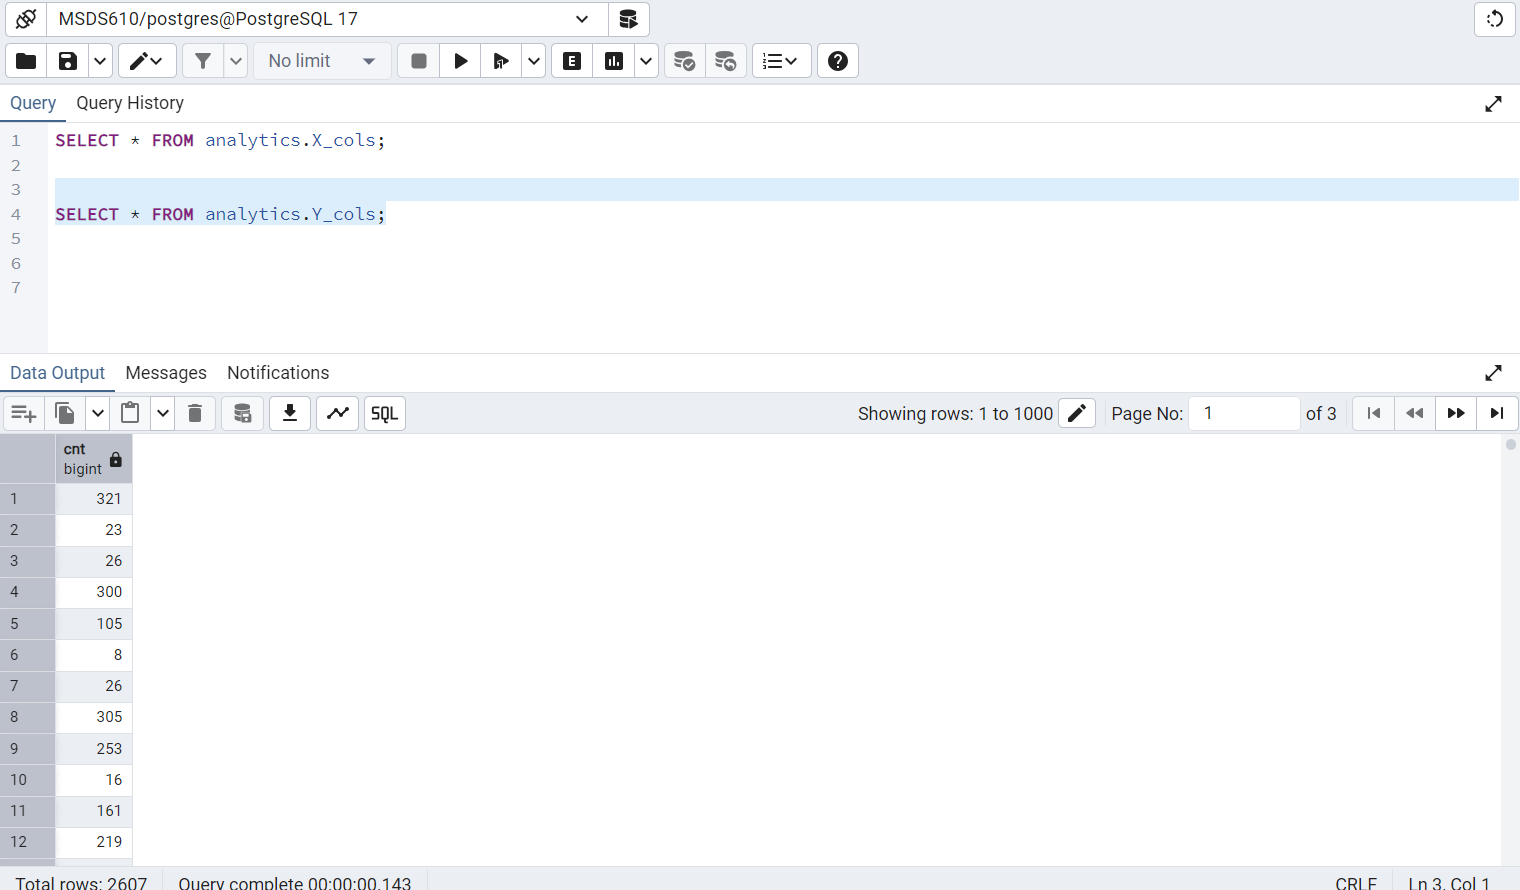

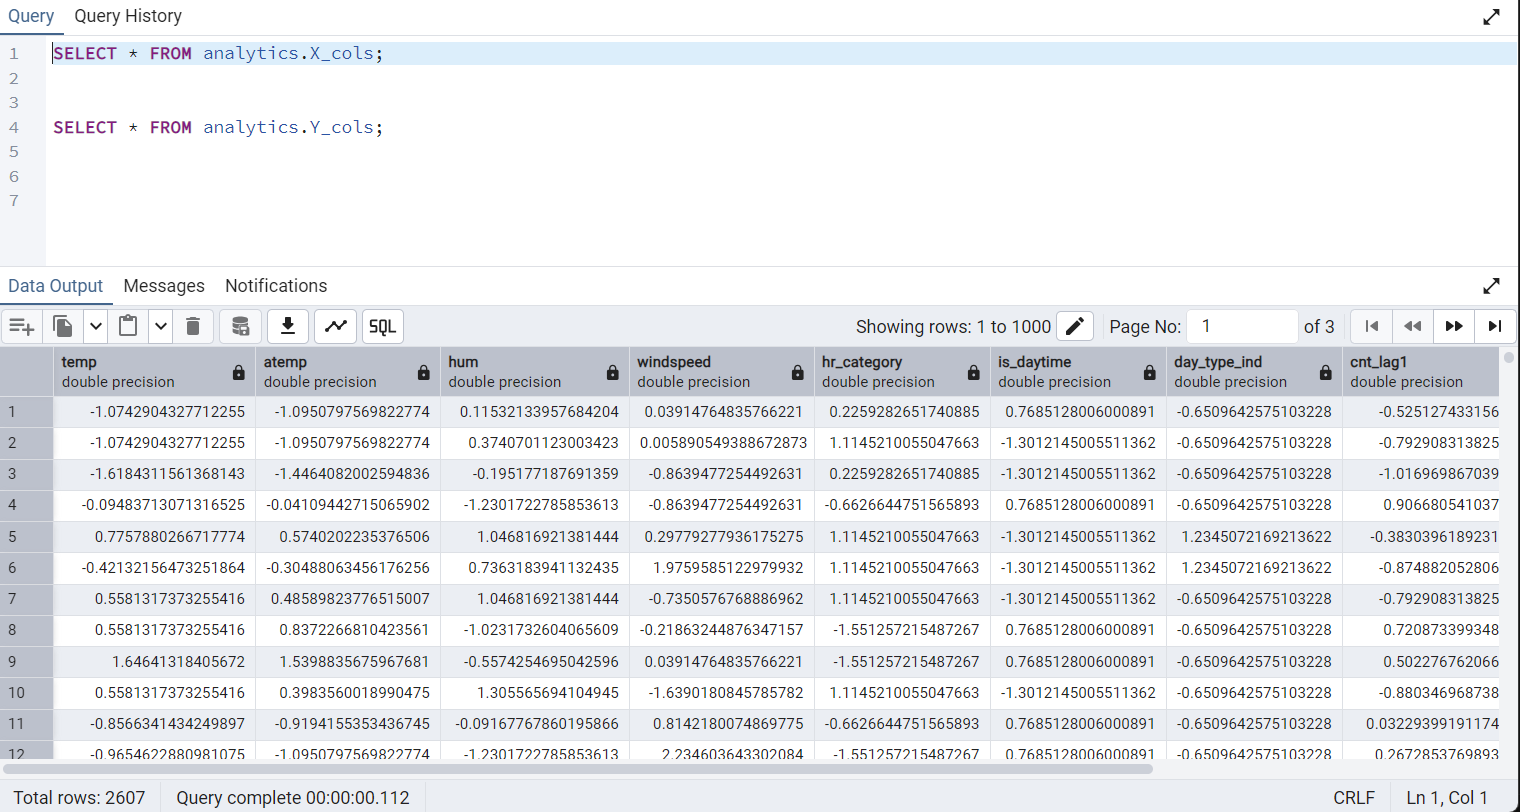